In [27]:
import os 
from typing import Annotated,List
from pydantic import BaseModel
from langchain_community.vectorstores import FAISS
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_groq.chat_models import ChatGroq
from langgraph.graph import StateGraph,START,END
from langchain_core.documents import Document


In [28]:
from dotenv import load_dotenv
load_dotenv()
os.environ['GROQ_API_KEY']=os.getenv('GROQ_API_KEY')
llm=ChatGroq(model='openai/gpt-oss-120b')

In [29]:
llm.invoke("Hi").content

'Hello! How can I help you today?'

In [30]:
from langchain_community.document_loaders import WebBaseLoader

urls = [
    "https://lilianweng.github.io/posts/2024-04-12-diffusion-video/",
    "https://lilianweng.github.io/posts/2023-06-23-agent/"
]

loaders = [WebBaseLoader(url) for url in urls]
docs = []
for ldr in loaders:
    docs.extend(ldr.load())

docs


[Document(metadata={'source': 'https://lilianweng.github.io/posts/2024-04-12-diffusion-video/', 'title': "Diffusion Models for Video Generation | Lil'Log", 'description': 'Diffusion models have demonstrated strong results on image synthesis in past years. Now the research community has started working on a harder task—using it for video generation. The task itself is a superset of the image case, since an image is a video of 1 frame, and it is much more challenging because:\n\nIt has extra requirements on temporal consistency across frames in time, which naturally demands more world knowledge to be encoded into the model.\nIn comparison to text or images, it is more difficult to collect large amounts of high-quality, high-dimensional video data, let along text-video pairs.\n\n\n\n🥑 Required Pre-read: Please make sure you have read the previous blog on “What are Diffusion Models?” for image generation before continue here.\n', 'language': 'en'}, page_content='\n\n\n\n\n\nDiffusion Model

In [31]:
splitter=RecursiveCharacterTextSplitter(chunk_size=100,chunk_overlap=20)
split_docs=splitter.split_documents(docs)


In [32]:
!pip install sentence_transformers

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [33]:
pip install sentence-transformers

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 26.0.1
[notice] To update, run: c:\Users\PARAS\Downloads\agentic-ai-langraph\.venv\Scripts\python.exe -m pip install --upgrade pip


In [34]:
#Embeddings
from langchain_huggingface import HuggingFaceEmbeddings
embeddings=HuggingFaceEmbeddings(
    model='sentence-transformers/all-MiniLM-L6-v2'
)

Loading weights: 100%|██████████| 103/103 [00:00<00:00, 707.40it/s, Materializing param=pooler.dense.weight]                             
BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [35]:
pip install faiss-gpu

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement faiss-gpu (from versions: none)

[notice] A new release of pip is available: 24.2 -> 26.0.1
[notice] To update, run: c:\Users\PARAS\Downloads\agentic-ai-langraph\.venv\Scripts\python.exe -m pip install --upgrade pip
ERROR: No matching distribution found for faiss-gpu


In [36]:
vectorstore=FAISS.from_documents(split_docs,embedding=embeddings)

In [37]:
retriever=vectorstore.as_retriever()

In [38]:
retriever.invoke("What are agents ")

[Document(id='779442e6-c70b-4275-8923-8fc6563c8b30', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, 

In [39]:
class RAGState(BaseModel):
    question:str 
    retrieved_docs:List[Document]=[]
    answer:str=""

In [40]:
#Adding the langgraph nodes
def retrieved_docs(state:RAGState)->RAGState:
    docs=retriever.invoke(state['messages'])
    return {"messages":state['messages'],"docs":docs}

In [ ]:
def generate_answer(state :RAGState)->RAGState:
    context="\n\n".join([doc.page_content for doc in state.retrieved_docs])
    prompt=f"Answer the quetion based on the context {Context} Question:{Question}"
    response=llm.invoke(prompt)
    return {"answer":response}
    return RAGState(question=question,context=context,answer=response.content)

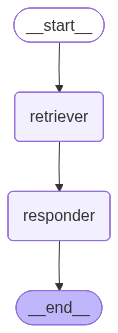

In [47]:
#Langgrpah
builder=StateGraph(RAGState)
builder.add_node("retriever",retrieved_docs)
builder.add_node("responder",generate_answer)
builder.set_entry_point("retriever")
builder.add_edge("retriever",'responder')
builder.add_edge("responder",END)
agent=builder.compile()
agent